#Ensaio sobre analisador supervisionado em partidas de Counter Strike: Global Offensive 


*   Guilherme Martiniano De Oliveira
guizera11@usp.br

*   
Renan Gomes Carneiro de Freitas
renangcfreitas@usp.br




##Importação de Bibliotecas

In [ ]:
from io import open
import requests

In [ ]:
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
import seaborn as sns

In [ ]:
!pip install -U scikit-learn

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn import metrics

##Extração de Dados do Arquivo

In [ ]:
#Path for the data file (external link)
#https://www.kaggle.com/christianlillelund/csgo-round-winner-classification
#https://github.com/Guimol/RedesNeuraisDataBase

path = 'https://raw.githubusercontent.com/Guimol/RedesNeuraisDataBase/main/csgo_round_snapshots.csv'

#Creating local file for the corpus
r = requests.get(path, allow_redirects=True)
open('data', 'wb').write(r.content)

#Trabalhando com o corpus
data = open('data', "r", encoding = "utf-8")

texto = data.read()

##Criação de Seed de controle

In [ ]:
SET_SEED = 420
np.random.seed(SET_SEED)

##Pré-Processamento dos Dados

In [ ]:
df = pd.read_csv('data')

###Remoção de Caso Absurdo (Outliers)

In [ ]:
#eliminar linha com t_players_alive = 6
indexToRemove = df[df['t_players_alive'] == 6].index.values[0]
df_novo = df.drop(indexToRemove)
#trazendo cada linha 1 index para cima
df_novo = df_novo.reset_index(drop=True)

###Separação em Dados Categoricos

In [ ]:
colunas = ['map']

df_categorical = pd.DataFrame(df_novo[colunas])

encoder = OneHotEncoder()

df_OneHotEncoder = encoder.fit_transform(df_categorical).toarray()
df_OneHotEncoder = pd.DataFrame(df_OneHotEncoder)

In [ ]:
nome_mapas = list(encoder.categories_[0])

dict_nomes = {}
for num in df_OneHotEncoder.columns:
  dict_nomes[num] = nome_mapas[num]

df_OneHotEncoder = df_OneHotEncoder.rename(columns=dict_nomes)

###Transformação em Dados Binários

In [ ]:
colunas = ['bomb_planted', 'round_winner']

df_binario = df_novo[colunas]
df_binario = df_binario.replace(False, 0)
df_binario = df_binario.replace(True, 1)
df_binario = df_binario.replace('CT', 0)
df_binario = df_binario.replace('T', 1)

In [ ]:
df_pre_divisao = pd.concat([df_OneHotEncoder, df_novo[['time_left', 'ct_score', 't_score', 'ct_health', 't_health', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'ct_total_util', 'tr_total_util']], df_binario], axis=1)

### Separação dos Dados de Teste e Treino

In [ ]:
df_pre_divisao['round_winner'].value_counts() / len(df_pre_divisao)

1    0.509807
0    0.490193
Name: round_winner, dtype: float64

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=SET_SEED)

In [ ]:
for treino_index, teste_index in split.split(df_pre_divisao, df_pre_divisao['round_winner']):
  df_treino_completo = df_pre_divisao.iloc[treino_index]
  df_teste = df_pre_divisao.iloc[teste_index]

for treino_index, teste_index in split.split(df_treino_completo, df_treino_completo['round_winner']):
  df_treino = df_treino_completo.iloc[treino_index]
  df_validacao = df_treino_completo.iloc[teste_index] 

###Transformação em Dados Numéricos

In [ ]:
colunas = ['time_left', 'ct_score', 't_score', 'ct_health', 't_health', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'ct_total_util', 'tr_total_util']

scaler = MinMaxScaler()

df_num_treino = df_treino[colunas]
df_num_validacao = df_validacao[colunas]
df_num_teste = df_teste[colunas]
df_num_completo = df_pre_divisao[colunas]

df_norm_treino = scaler.fit_transform(df_num_treino)
df_norm_treino = pd.DataFrame(df_norm_treino)

df_norm_validacao = scaler.transform(df_num_validacao)
df_norm_validacao = pd.DataFrame(df_norm_validacao)

df_norm_teste = scaler.transform(df_num_teste)
df_norm_teste = pd.DataFrame(df_norm_teste)

df_norm_completo = scaler.fit_transform(df_num_completo)
df_norm_completo = pd.DataFrame(df_norm_completo)

In [ ]:
dict_nomes = {}
for num in df_norm_teste.columns:
  dict_nomes[num] = colunas[num]

df_norm_treino = df_norm_treino.rename(columns=dict_nomes)
df_norm_validacao = df_norm_validacao.rename(columns=dict_nomes)
df_norm_teste = df_norm_teste.rename(columns=dict_nomes)
df_norm_completo = df_norm_completo.rename(columns=dict_nomes)

###Junção das novas tabelas

In [ ]:
cat_feat =  list(df_pre_divisao.select_dtypes(exclude='object'))
cat_feat = cat_feat[0:8] + cat_feat[18:20]

In [ ]:
df_treino_final = pd.concat([df_norm_treino, df_treino[cat_feat].reset_index(drop=True)], axis=1)
df_validacao_final = pd.concat([df_norm_validacao, df_validacao[cat_feat].reset_index(drop=True)], axis=1)
df_teste_final = pd.concat([df_norm_teste, df_teste[cat_feat].reset_index(drop=True)], axis=1)

In [ ]:
df_completo_final = pd.concat([df_norm_completo, df_pre_divisao[cat_feat].reset_index(drop=True)], axis=1)
df_completo_final = df_completo_final.sample(frac=1, random_state=SET_SEED).reset_index(drop=True)

###Conjuntos X e Y (separado em 70% treino + validação e 30% teste)

In [ ]:
tam = df_pre_divisao.shape[1] - 1

X_treino = df_treino_final.iloc[:,:tam]
X_validacao = df_validacao_final.iloc[:,:tam]
X_teste = df_teste_final.iloc[:,:tam]

In [ ]:
y_treino = pd.DataFrame(df_treino_final.iloc[:,tam])
y_validacao = pd.DataFrame(df_validacao_final.iloc[:,tam])
y_teste = pd.DataFrame(df_teste_final.iloc[:,tam])

###Conjunto X e Y (para cross-validation)

In [ ]:
tam = df_pre_divisao.shape[1] - 1

X_cross_valid = df_completo_final.iloc[:,:tam]
Y_cross_valid = pd.DataFrame(df_completo_final.iloc[:,tam])

##Processamento

###Busca dos melhores parâmetros para o classificador usando cross-validation

In [ ]:
param_grid = [{'hidden_layer_sizes': [2, (16, 4), (4, 4, 4)], 'solver': ['adam', 'sgd'], 'activation': ['tanh', 'relu', 'logistic'], 'learning_rate_init': [0.001, 0.05], 'max_iter': [400]}]

mlp = MLPClassifier(random_state=SET_SEED)

In [ ]:
grid_search = GridSearchCV(mlp, param_grid, cv = 5, scoring = 'accuracy')

grid_search.fit(X_cross_valid, Y_cross_valid.values.ravel())

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=420),
             param_grid=[{'activation': ['tanh', 'relu', 'logistic'],
                          'hidden_layer_sizes': [2, (16, 4), (4, 4, 4)],
                          'learning_rate_init': [0.001, 0.05],
                          'max_iter': [400], 'solver': ['adam', 'sgd']}],
             scoring='accuracy')

###Busca dos melhores parâmetros para o classificador usando splitting 

In [ ]:
score_split = 0
for param_atual in ParameterGrid(param_grid):
  mlp.set_params(**param_atual)
  mlp.fit(X_treino, y_treino.values.ravel())
  score_atual = mlp.score(X_validacao, y_validacao.values.ravel())
  if score_atual > score_split:
    score_split = score_atual
    params_split = param_atual

##Avaliação do melhor modelo

###Matriz de Confusão e Parâmetros Derivados

In [ ]:
def avaliador_modelo(y_real, y_predito):
    acuracia = metrics.accuracy_score(y_real, y_predito)
    precisao = metrics.precision_score(y_real, y_predito)
    recall = metrics.recall_score(y_real, y_predito)
    f1 = metrics.f1_score(y_real, y_predito)
    matriz_confusao = metrics.confusion_matrix(y_real, y_predito)
    
    print('Acurácia: {:.2f}'.format(acuracia))
    print('Precisão: {:.2f}'.format(precisao))
    print('Recall: {:.2f}'.format(recall))
    print('F1_score: {:.2f}'.format(f1))
    print('\nMatriz de Confusão: \n', matriz_confusao)

    return float(acuracia), float(precisao), float(recall), float(f1), matriz_confusao

###Avaliando usando a separacao por cross-validation

In [ ]:
skfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state=SET_SEED)

params_cv = grid_search.best_params_
params_cv['random_state'] = SET_SEED

mlpCV = MLPClassifier(**params_cv)

i, VP_total, FP_total, FN_total, VN_total = 0, 0, 0, 0, 0

for treino_indice, teste_indice in skfolds.split(X_cross_valid, Y_cross_valid):
  clone_mlpCV = clone(mlpCV)
  X_treinoCV = X_cross_valid.iloc[treino_indice,:]
  y_treinoCV = Y_cross_valid.iloc[treino_indice,:]
  X_testeCV = X_cross_valid.iloc[teste_indice,:]
  y_testeCV = Y_cross_valid.iloc[teste_indice,:]
  
  clone_mlpCV.fit(X_treinoCV, y_treinoCV.values.ravel())
  y_predCV = clone_mlpCV.predict(X_testeCV)

  matriz_confusao = metrics.confusion_matrix(y_testeCV, y_predCV)

  VP_total = VP_total + matriz_confusao[0][0]
  FN_total = FN_total + matriz_confusao[0][1]
  FP_total = FP_total + matriz_confusao[1][0]
  VN_total = VN_total + matriz_confusao[1][1]

In [ ]:
total = VP_total + FN_total + FP_total + VN_total

acuracia_cv = (VP_total + VN_total) / total
precisao_cv = VP_total / (VP_total + FP_total)
recall_cv = VP_total / (VP_total + FN_total)
f1_score_cv = 2 * ((precisao_cv * recall_cv) / (precisao_cv + recall_cv))

matriz_confusao_cv = np.reshape([VP_total, FN_total, FP_total, VN_total], (2,2))

print("Acurácia: {:.2f}".format(acuracia_cv))
print("Precisão: {:.2f}".format(precisao_cv))
print("Recall: {:.2f}".format(recall_cv))
print("F1_score: {:.2f}".format(f1_score_cv))
print('\nMatriz de Confusão: \n', matriz_confusao_cv)

Acurácia: 0.74
Precisão: 0.74
Recall: 0.72
F1_score: 0.73

Matriz de Confusão: 
 [[43277 16727]
 [15112 47293]]


###Avaliando usando a separacao por splitting (separado em 70% treino + validação e 30% treino)

In [ ]:
mlp.set_params(**params_split)
mlp.fit(X_treino, y_treino.values.ravel())
y_predito_teste = mlp.predict(X_teste)

acuracia_split, precisao_split, recall_split, f1_score_split, matriz_confusao_splitting = avaliador_modelo(y_teste, y_predito_teste)

Acurácia: 0.74
Precisão: 0.73
Recall: 0.76
F1_score: 0.75

Matriz de Confusão: 
 [[12836  5165]
 [ 4403 14319]]


##Conclusão sobre os melhores parâmetros e melhor acurácia dos métodos

In [ ]:
melhor_acuracia = acuracia_split > acuracia_cv

if(params_split == params_cv):
  print(f"Ambos métodos de separação encontraram os mesmos melhores parâmetros: {params_split}")
elif(melhor_acuracia):
  print(f"Os métodos de separação resultaram em parâmetros diferentes.\nPorém splitting teve a maior acurácia com os seguintes parâmetros: {params_split}")
else:
  print(f"Os métodos de separação resultaram em parâmetros diferentes.\nPorém cross-validation teve a maior acurácia com os seguintes parâmetros: {params_cv}")

if(melhor_acuracia):
  print(f"Maior Acurácia Splitting: {acuracia_split}")
else:
  print(f"Maior Acurácia Cross-Validation: {acuracia_cv}")

print(f"Diferença: |{acuracia_split} - {acuracia_cv}| = {abs(acuracia_split - acuracia_cv)}")

Os métodos de separação resultaram em parâmetros diferentes.
Porém cross-validation teve a maior acurácia com os seguintes parâmetros: {'activation': 'tanh', 'hidden_layer_sizes': (16, 4), 'learning_rate_init': 0.001, 'max_iter': 400, 'solver': 'adam', 'random_state': 420}
Maior Acurácia Cross-Validation: 0.7398965762321398
Diferença: |0.7394548375677369 - 0.7398965762321398| = 0.0004417386644028909


##Plotagem das métricas



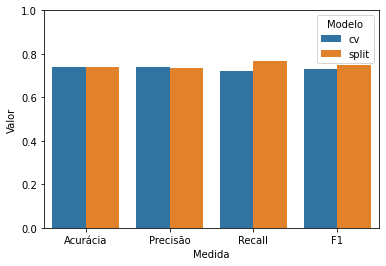

In [ ]:
metrics, m1, m2, values = ['Acurácia', 'Precisão', 'Recall', 'F1'], ['cv'], ['split'], [acuracia_cv, precisao_cv, recall_cv, f1_score_cv, acuracia_split, precisao_split, recall_split, f1_score_split]
dataToPlot = {'Valor': values, 'Medida': metrics*2, 'Modelo': (m1*4)+(m2*4)}
dataToPlot_df = pd.DataFrame(dataToPlot)
plotOfMetricsPerModel = sns.barplot(x="Medida", y='Valor', hue="Modelo", data=dataToPlot_df).set(ylim=(0, 1))

In [ ]:
totalSumCV = np.sum(matriz_confusao_cv)
totalSumSP = np.sum(matriz_confusao_splitting)
matrixCVForPlotting = np.empty([2, 2])
matrixSPForPlotting = np.empty([2, 2])

for i in range(len(matriz_confusao_cv)): 
  for j in range(len(matriz_confusao_cv[i])): matrixCVForPlotting[i][j] = matriz_confusao_cv[i][j]/totalSumCV*100

for i in range(len(matriz_confusao_splitting)): 
  for j in range(len(matriz_confusao_splitting[i])): matrixSPForPlotting[i][j] = matriz_confusao_splitting[i][j]/totalSumSP*100

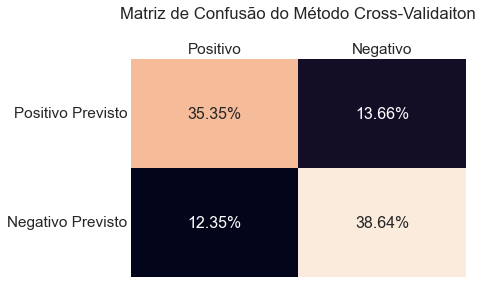

In [ ]:
sns.set(font_scale=1.4)

cols = ['Positivo', 'Negativo']
inds = ['Positivo Previsto', 'Negativo Previsto']
mcCV = pd.DataFrame(matrixCVForPlotting, columns=cols, index=inds)
mcSP = pd.DataFrame(matrixSPForPlotting, columns=cols, index=inds)

mcCVPlot = sns.heatmap(mcCV, annot=True, annot_kws={"size": 16}, fmt='.2f', cbar=False)
mcCVPlot.xaxis.tick_top()
mcCVPlot.set_title('Matriz de Confusão do Método Cross-Validaiton\n')
mcCVPlot.tick_params(length=0)
for t in mcCVPlot.texts: t.set_text(t.get_text() + "%")

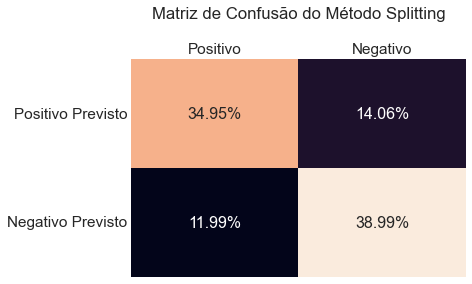

In [ ]:
mcSPPlot = sns.heatmap(mcSP, annot=True, annot_kws={"size": 16}, fmt='.2f', cbar=False)
mcSPPlot.xaxis.tick_top()
mcSPPlot.set_title('Matriz de Confusão do Método Splitting\n')
mcSPPlot.tick_params(length=0)
for u in mcSPPlot.texts: u.set_text(u.get_text() + "%")